In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from sklearn.preprocessing import MinMaxScaler 
from sklearn.utils import resample

### Conenctando con Google Drive para obtener las imagenes.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Cargar datos

In [ ]:
import pandas as pd
import numpy as np

data_path = '/content/gdrive/MyDrive/ColabNotebooks/DeepLearning/DemandPrediction/Data'
df = pd.read_excel(data_path + '/data-03-07.xlsx', index_col='date')

In [ ]:

data = df
# data[data>0] = 0
every_sampling = int(len(data)/(30))
print(len(data))
data.head()

88367


,outputStatus,voltage.V1,voltage.V2,voltage.V3,current.I1,current.I2,current.I3,activePower.kWL1,activePower.kWL2,activePower.kWL3,...,currentTHD.I2THD,currentTHD.I3THD,kVAhLow,kVAhHigh,pkW,pkVA,PFi,currentTDD.I1TDD,currentTDD.I2TDD,currentTDD.I3TDD
date,,,,,,,,,,,,,,,,,,,,,
2022-03-13 16:57:23,0,123.3,123.3,123.4,34.24,33.84,28.60,-4.199,4.130,3.439,...,12.2,22.8,5257.0,67.0,3.197,12.011,0.636,1.7,2.0,3.2
2022-03-13 16:59:23,0,132.6,132.8,133.7,2.60,0.44,2.68,0.190,0.052,0.294,...,4.1,62.2,7981.0,5.0,-0.017,-0.017,0.973,0.4,0.0,0.7
2022-03-13 17:01:24,0,130.9,131.1,131.2,2.00,30.48,0.92,0.225,2.817,0.086,...,4.9,26.0,318.0,19.0,-0.017,-0.017,0.981,0.3,0.7,0.1
2022-03-13 17:03:23,0,124.4,124.4,125.6,14.76,19.36,17.76,1.504,1.849,1.815,...,11.3,5.6,7017.0,37.0,-0.017,-0.017,0.969,0.7,1.0,0.5
2022-03-13 17:05:23,0,124.4,124.6,125.6,14.72,11.96,17.56,1.504,1.262,1.780,...,18.5,5.6,7017.0,37.0,-0.017,-0.017,0.969,0.7,1.0,0.5


### Selcción de potencia activa y remover valores negativos

In [ ]:
active_power = data.reset_index()['TkW']
df1 = active_power[active_power>0]
df1 = df1.dropna()

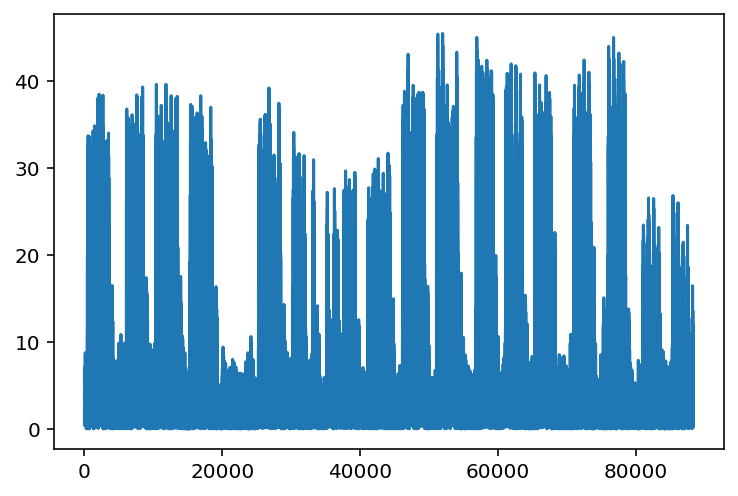

In [ ]:
plt.plot(df1)

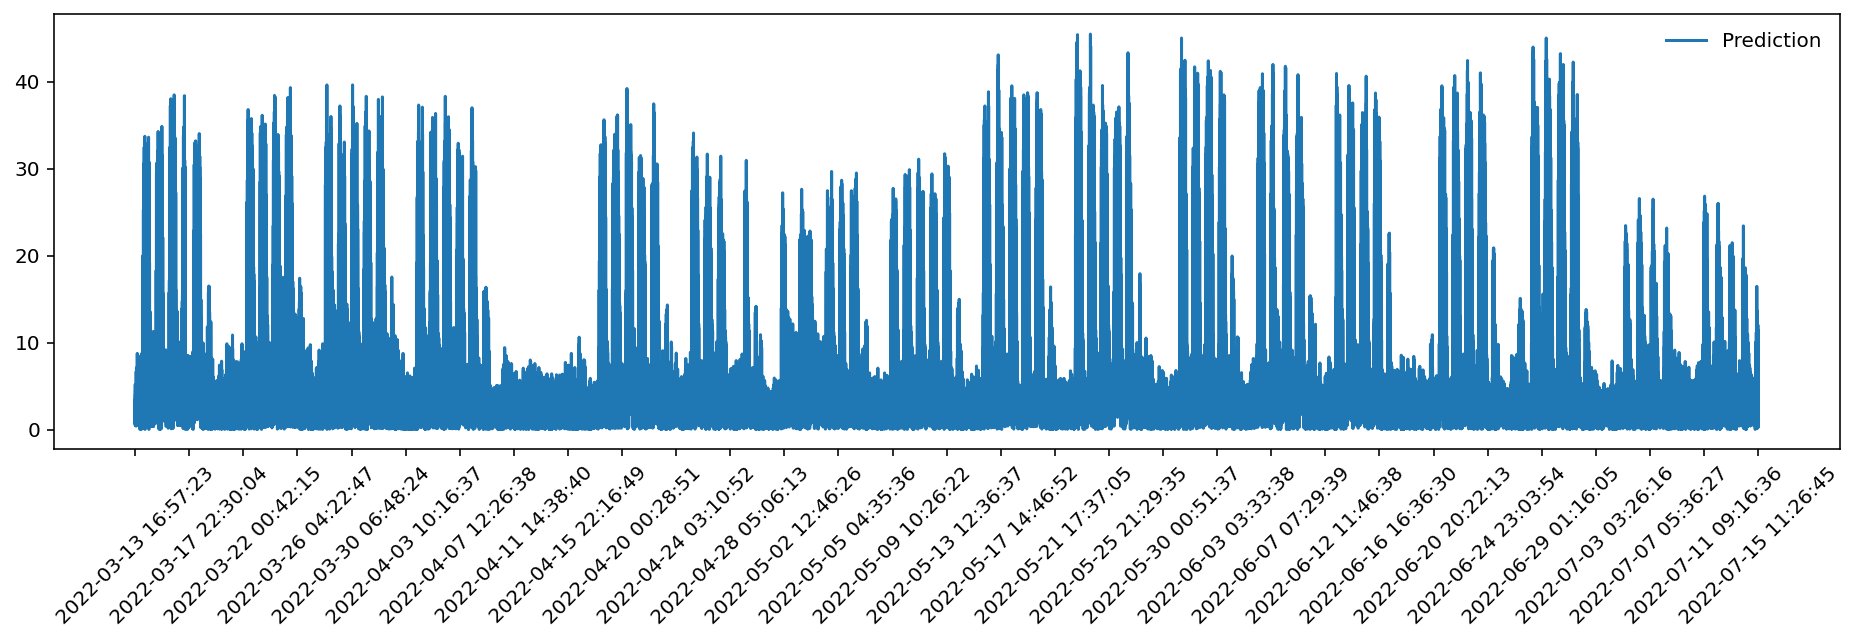

In [ ]:
datesx = data.reset_index()['date']
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(df1, label='Prediction')
ax.set_xticks(np.arange(len(datesx))[::every_sampling])
ax.set_xticklabels(datesx[::every_sampling], rotation=45)
ax.legend(frameon=False)

### Normalización

In [ ]:
scalar = MinMaxScaler(feature_range=(0,1))
df1 = scalar.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
##splitting dataset into train and test split for time series data
batch_size = 64

training_size=int(len(df1)*0.65)
forcast_size = batch_size
test_size=len(df1)-training_size - forcast_size
train_data,test_data,forcast_data = df1[0:training_size,:],df1[training_size:len(df1)-forcast_size,:1],df1[len(df1)-forcast_size:len(df1),:]


print(len(train_data))
print(len(test_data))

51123
27464


In [ ]:
seq_len = 100
class StockDataset(Dataset):
    def __init__(self,data,seq_len = 100):
        self.data = data
        self.data = torch.from_numpy(data).float().view(-1)
        self.seq_len = seq_len
        
    def __len__(self):
        return len(self.data)-self.seq_len-1

    def __getitem__(self, index) :
        return  self.data[index : index+self.seq_len] , self.data[index+self.seq_len]


train_dataset = StockDataset(train_data, seq_len) 
test_dataset = StockDataset(test_data, seq_len) 

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size , drop_last=True)
print(len(train_dataloader))
device = "cuda" if torch.cuda.is_available() else "cpu"

797


In [89]:
class LstmModel(nn.Module):
    def __init__(self, input_dim , hidden_size , num_layers, drop_prob=0.2):
        super(LstmModel, self).__init__()
        self.num_layers = num_layers
        self.input_size = input_dim
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size=input_dim , hidden_size = hidden_size , num_layers= num_layers )
        self.dropout = nn.Dropout(drop_prob)

        self.fc = nn.Linear(hidden_size,1)

    def forward(self,x,hn,cn):
        out , (hn,cn) = self.lstm(x , (hn,cn))

        out = self.dropout(out)

        final_out = self.fc(out[-1])
        return final_out,hn,cn

    def init(self):
        h0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        c0 =  torch.zeros(self.num_layers , batch_size , self.hidden_size).to(device)
        return h0 , c0


input_dim = 1 
hidden_size = 50
num_layers = 2

model = LstmModel(input_dim , hidden_size , num_layers).to(device)
model

LstmModel(
  (lstm): LSTM(1, 50, num_layers=2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def train(dataloader):
    global train_loss
    hn , cn = model.init()
    model.train()
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(seq_len,batch_size,1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
        hn = hn.detach()
        cn = cn.detach()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

In [ ]:
def test(dataloader):
    global valid_loss
    hn , cn = model.init()
    model.eval()
    for batch , item in enumerate(dataloader):
        x , y = item
        x = x.to(device)
        y = y.to(device)
        out , hn , cn = model(x.reshape(seq_len,batch_size,1),hn,cn)
        loss = loss_fn(out.reshape(batch_size) , y)
        valid_loss += loss.item()

In [ ]:
epochs = 100
valid_loss_min = np.Inf # track change in validation loss
train_losses, test_losses = [], []
for epoch in range(epochs):
    train_loss = 0.0
    valid_loss = 0.0
    print(f"epoch {epoch} ")
    train(train_dataloader)
    test(test_dataloader)
    # calculate average losses
    train_loss = train_loss/len(train_dataloader)
    valid_loss = valid_loss/len(test_dataloader)
    
    train_losses.append(train_loss)
    test_losses.append(valid_loss)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'demand_prediction.pt')
        valid_loss_min = valid_loss

epoch 0 
Epoch: 0 	Training Loss: 0.017546 	Validation Loss: 0.014641
Validation loss decreased (inf --> 0.014641).  Saving model ...
epoch 1 
Epoch: 1 	Training Loss: 0.013945 	Validation Loss: 0.013936
Validation loss decreased (0.014641 --> 0.013936).  Saving model ...
epoch 2 
Epoch: 2 	Training Loss: 0.013683 	Validation Loss: 0.013544
Validation loss decreased (0.013936 --> 0.013544).  Saving model ...
epoch 3 
Epoch: 3 	Training Loss: 0.013071 	Validation Loss: 0.013051
Validation loss decreased (0.013544 --> 0.013051).  Saving model ...
epoch 4 
Epoch: 4 	Training Loss: 0.012465 	Validation Loss: 0.012757
Validation loss decreased (0.013051 --> 0.012757).  Saving model ...
epoch 5 
Epoch: 5 	Training Loss: 0.012180 	Validation Loss: 0.012521
Validation loss decreased (0.012757 --> 0.012521).  Saving model ...
epoch 6 
Epoch: 6 	Training Loss: 0.012044 	Validation Loss: 0.012182
Validation loss decreased (0.012521 --> 0.012182).  Saving model ...
epoch 7 
Epoch: 7 	Training Loss

### Cargar mejor modelo

In [90]:
model.load_state_dict(torch.load('demand_prediction.pt'))

<All keys matched successfully>

### Visualizar errores

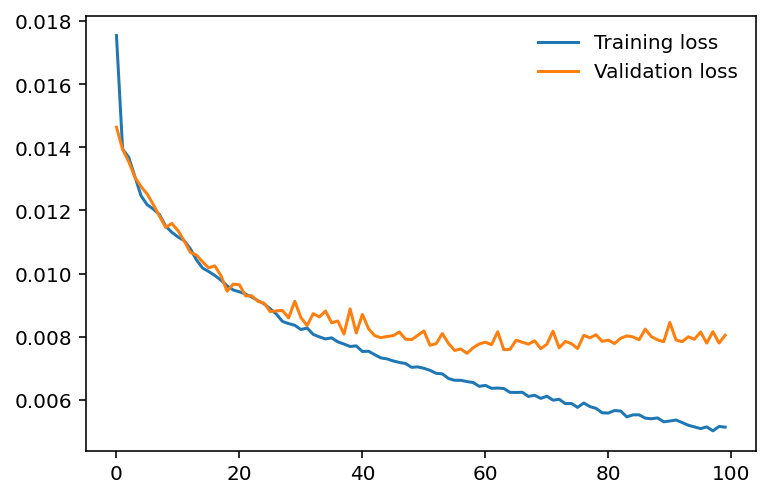

In [93]:
#Visualiza los errores de entrenamiento y validación
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
import math
import random
from sklearn.metrics import mean_squared_error
import numpy as np
def calculate_metrics(data_loader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn , cn = model.init()
        for batch , item in enumerate(data_loader):
            x , y = item
            x , y = x.to(device) , y.to(device)
            x = x.view(seq_len,batch_size,1)
            pred = model(x,hn,cn)[0]
            pred = scalar.inverse_transform(pred.detach().cpu().numpy()).reshape(-1)
            y = scalar.inverse_transform(y.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)
            
        ind = random.randint(0, 99)
        print(pred_arr[ind],y_arr[ind])
        return math.sqrt(mean_squared_error(y_arr,pred_arr)), pred_arr, y_arr

In [ ]:
def forecasting(data_loader):
    pred_arr = []
    y_arr = []
    with torch.no_grad():
        hn , cn = model.init()
        last_pred = None
        last_x = None
        for batch , item in enumerate(data_loader):
            x , y = item
            x , y = x.to(device) , y.to(device)
            x = x.view(seq_len,batch_size,1)
            last_x = x
            pred, hn, cn = model(x,hn,cn)
            last_pred = pred
            pred = scalar.inverse_transform(pred.detach().cpu().numpy()).reshape(-1)
            y = scalar.inverse_transform(y.detach().cpu().numpy().reshape(1,-1)).reshape(-1)
            pred_arr = pred_arr + list(pred)
            y_arr = y_arr + list(y)

        out = torch.empty(seq_len,batch_size, 1).to(device)
        out[[item+1 for item in range(seq_len-1)],:] = last_x[[item+1 for item in range(seq_len-1)],:].to(device)
        out[seq_len-1,:] = last_pred
        pred, hn, cn = model(out,hn,cn)
        pred = scalar.inverse_transform(pred.detach().cpu().numpy()).reshape(-1)
        pred_arr = pred_arr + list(pred)
        return pred_arr, y_arr

pred_arr, y_arr = forecasting(test_dataloader)


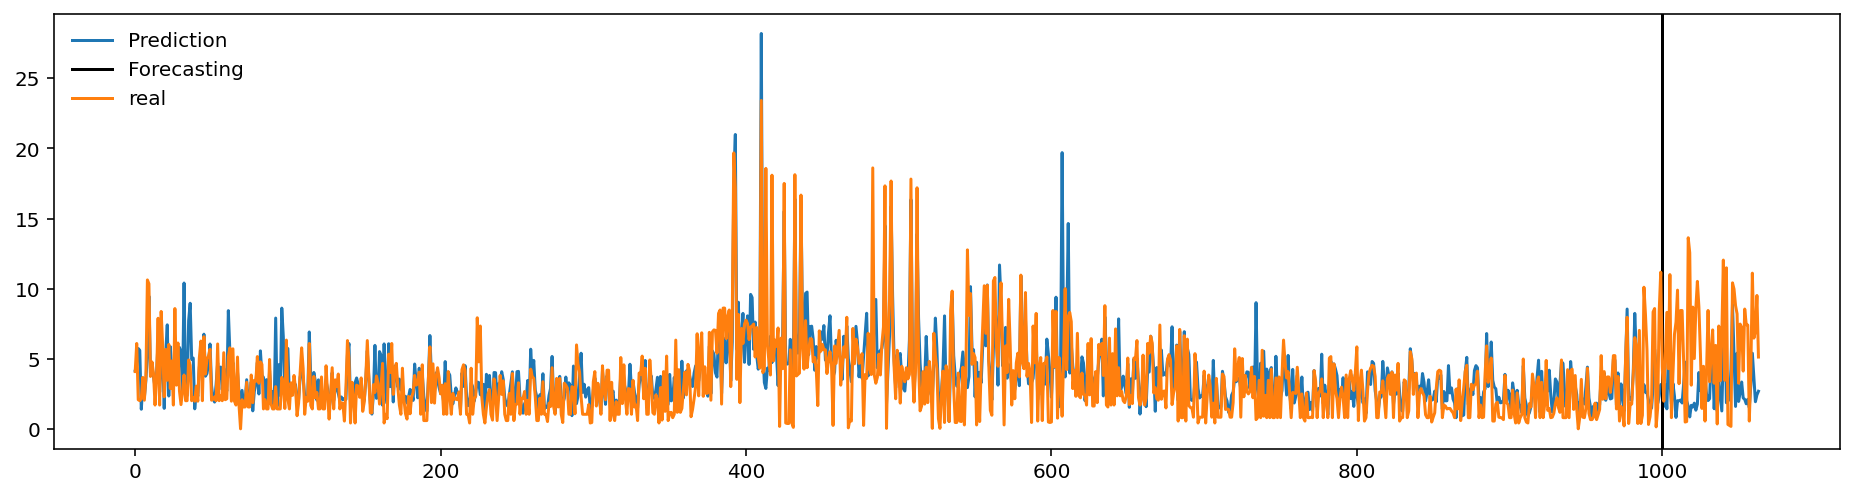

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
data_fc = y_arr[-1000:]
data_fc.extend(scalar.inverse_transform(forcast_data.reshape(1,-1)).reshape(-1))
ax.plot(pred_arr[-1000-batch_size:], label='Prediction')
plt.axvline(x = 1000, color = 'k', label = 'Forecasting')
ax.plot(data_fc, label='real')
ax.legend(frameon=False)

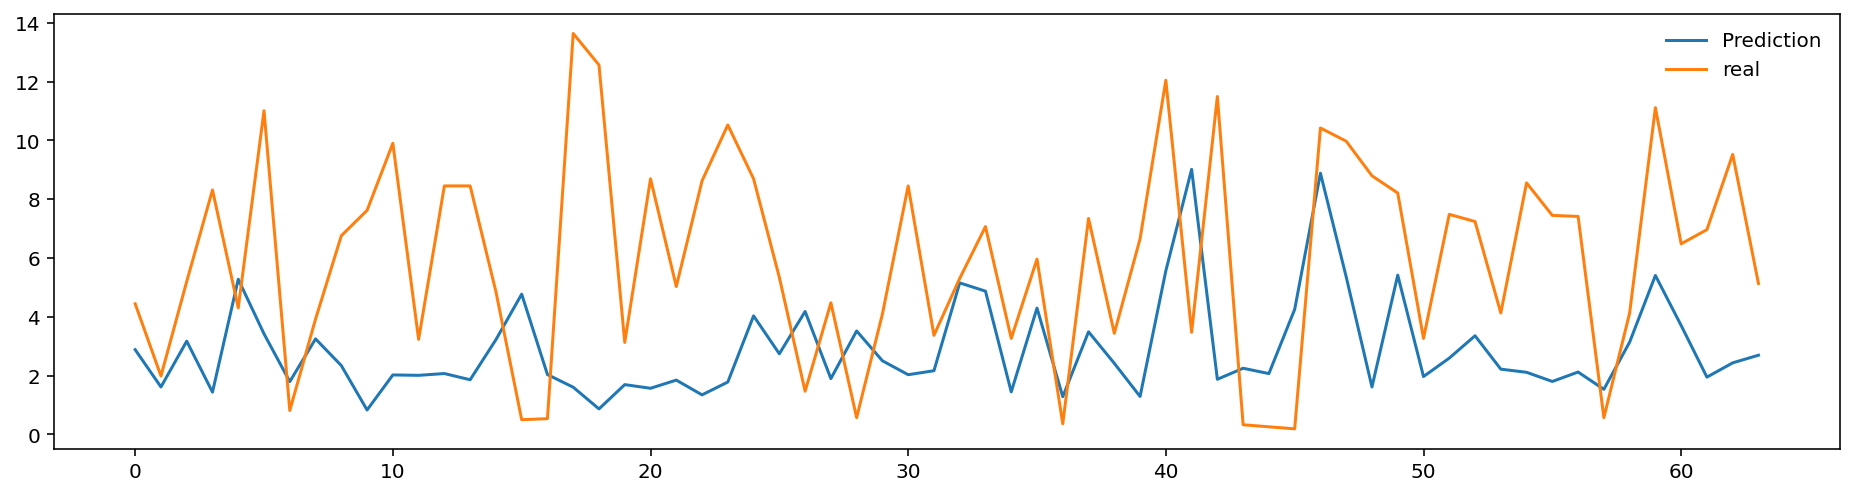

In [ ]:
test_data = scalar.inverse_transform(forcast_data.reshape(1,-1)).reshape(-1)
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(pred_arr[-batch_size:], label='Prediction')
ax.plot(test_data, label='real')
ax.legend(frameon=False)

In [ ]:
# calculating final loss metrics
metric, pred_arr, y_arr = calculate_metrics(train_dataloader)

print(f"train mse loss {metric}")

5.0786533 5.133
train mse loss 3.6067265293232613


In [ ]:
print(len(pred_arr))

51008


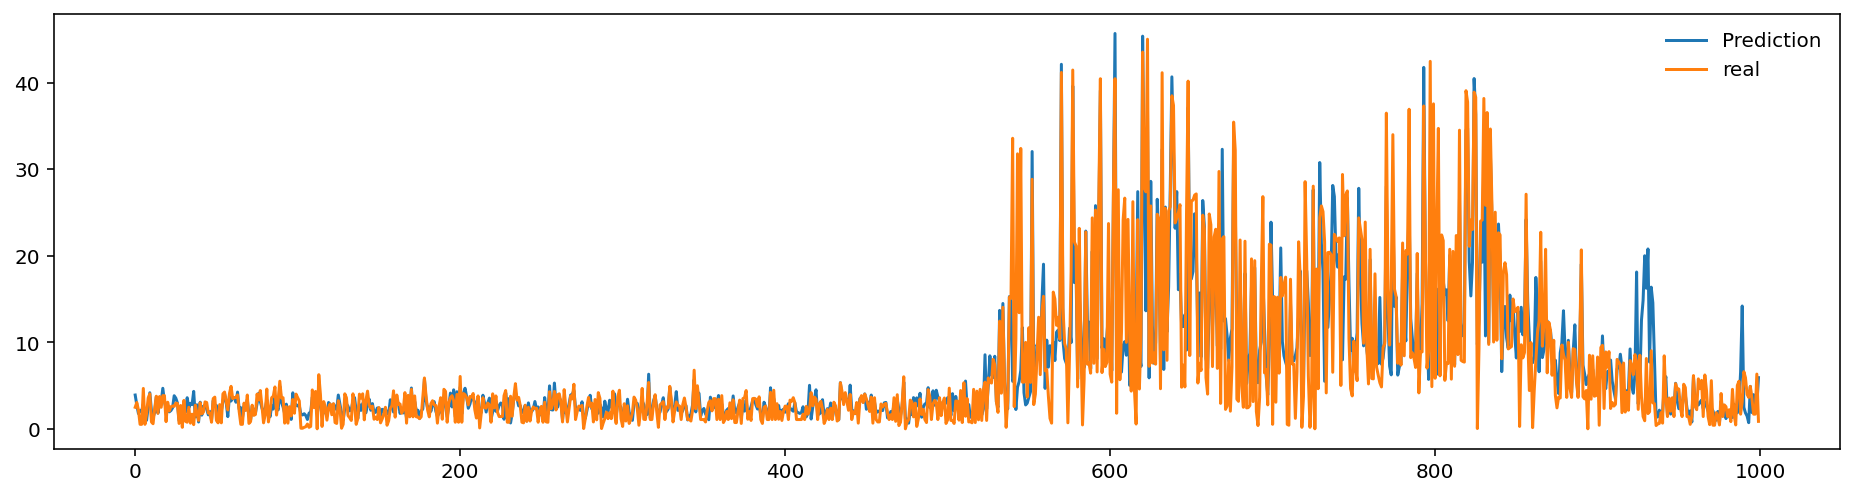

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(pred_arr[-1000:], label='Prediction')
ax.plot(y_arr[-1000:], label='real')
ax.legend(frameon=False)

In [ ]:
# calculating final loss metrics
metric, pred_arr, y_arr = calculate_metrics(test_dataloader)

print(f"train mse loss {metric}")

4.5106034 0.778
train mse loss 3.9125135330112397


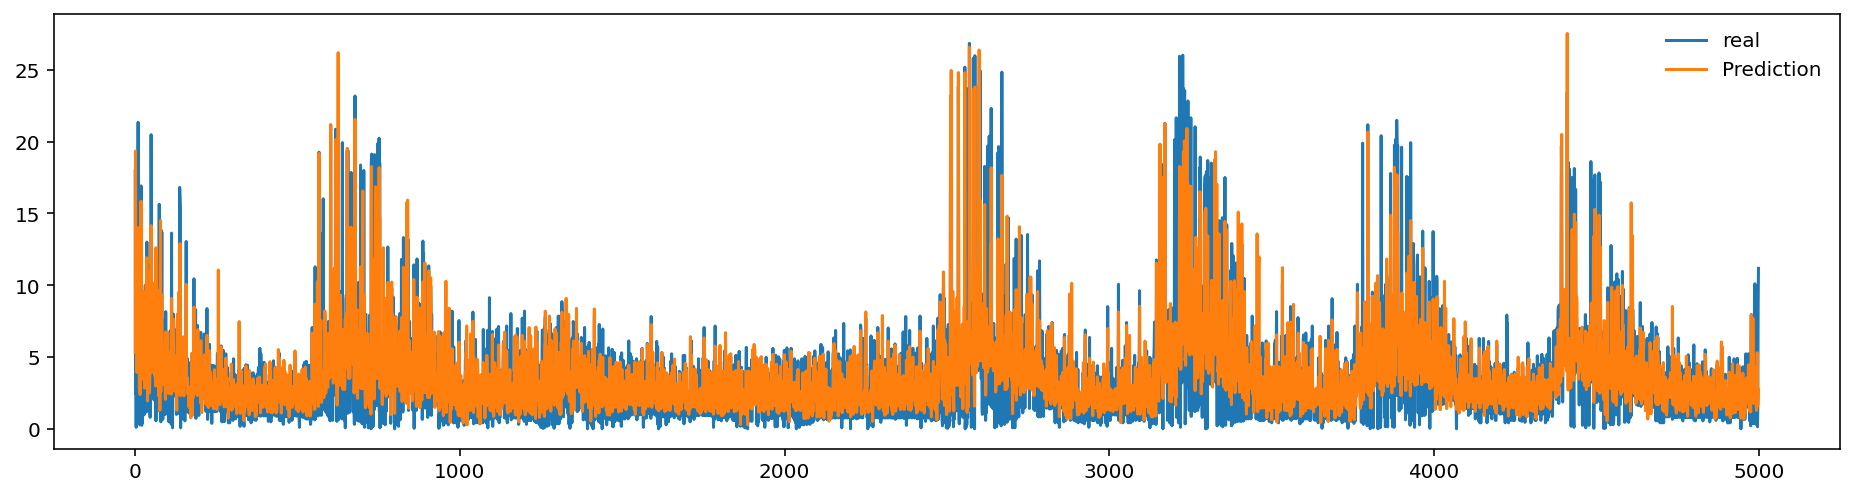

In [ ]:
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(y_arr[-5000:], label='real')
ax.plot(pred_arr[-5000:], label='Prediction')
ax.legend(frameon=False)